In [139]:
import requests
from datetime import datetime, timedelta
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
import pickle

In [4]:
match_df = pd.read_csv('pro_match_ids_march_2023.csv')
match_ids = match_df['Match ID'].tolist()

In [5]:
# set up API URL and parameters
api_url = 'https://api.opendota.com/api/matches/{}/'

# initialize empty list to store results
results = []
max_attempts = 3

# loop through match IDs and retrieve relevant data
for match_id in match_ids[:500]:
    # send GET request to API
    response = requests.get(api_url.format(match_id))
    
    # initialize number of attempts to 0
    num_attempts = 0
    while num_attempts < max_attempts:

        # check if request was successful
        if response.status_code == 200:
            # extract relevant data from response JSON
            data = response.json()
            players = data['players']

            # loop through each player in the match and extract relevant data
            for player in players:
                hero_id = player['hero_id']
                player_slot = player['player_slot']
                team = 'Radiant' if player_slot < 128 else 'Dire'
                lane_start = player['lane']
                lane_pos = player['lane_pos']
                # add data to results list
                results.append({
                    'match_id': match_id,
                    'hero_id': hero_id,
                    'player_slot': player_slot,
                    'team': team,
                    'lane_start': lane_start,
                    'lane_pos': lane_pos
                })
            break
        else:
            print(f"Error retrieving data for match ID {match_id}.")
            num_attempts += 1
            time.sleep(60)
            
    if num_attempts == max_attempts:
        print(f"Unable to retrieve data from OpenDota API for match ID {match_id}. Moving on to next match.")

    # print progress every 100 matches
    if len(results) % 1000 == 0:
        print(f"Processed data for {len(results)} players in {len(results)/10} matches.")

    # break loop if we have processed data for 100000 players
#     if len(results) >= 100000:
#         break

non_retrieved_data = match_ids[500:]

# convert results to pandas DataFrame
players_df = pd.DataFrame(results)
players_df.head()

Error retrieving data for match ID 7082573416.
Error retrieving data for match ID 7082573416.
Error retrieving data for match ID 7082573416.
Unable to retrieve data from OpenDota API for match ID 7082573416. Moving on to next match.
Processed data for 1000 players in 100.0 matches.
Error retrieving data for match ID 7081100552.
Error retrieving data for match ID 7081100552.
Error retrieving data for match ID 7081100552.
Unable to retrieve data from OpenDota API for match ID 7081100552. Moving on to next match.
Processed data for 2000 players in 200.0 matches.
Error retrieving data for match ID 7079820802.
Error retrieving data for match ID 7079820802.
Error retrieving data for match ID 7079820802.
Unable to retrieve data from OpenDota API for match ID 7079820802. Moving on to next match.
Error retrieving data for match ID 7079017855.
Error retrieving data for match ID 7079017855.
Error retrieving data for match ID 7079017855.
Unable to retrieve data from OpenDota API for match ID 70790

,hero_id,lane_pos,lane_start,match_id,player_slot,team
0,70,"{'72': {'78': 4}, '74': {'74': 1}, '76': {'76'...",1,7083727502,0,Radiant
1,120,"{'70': {'78': 6}, '72': {'78': 2, '80': 6}, '7...",2,7083727502,1,Radiant
2,33,"{'70': {'140': 18, '142': 3}, '72': {'78': 1, ...",3,7083727502,2,Radiant
3,86,"{'70': {'138': 1, '140': 1, '142': 1}, '72': {...",2,7083727502,3,Radiant
4,75,"{'72': {'78': 5, '80': 1}, '74': {'74': 3, '76...",1,7083727502,4,Radiant


In [8]:
players_df.to_csv('lane_data.csv', index=False)

In [112]:
players_df = pd.read_csv("lane_data.csv")

In [141]:
lane_pos = players_df['lane_pos']

earthshaker_rows = players_df[players_df['hero_id']==7][['lane_pos', 'team'] ]

# Assign numeric values to all non-numeric features
earthshaker_rows['team'] = earthshaker_rows['team'].replace({'Radiant': 1, 'Dire': 0})

print(type(earthshaker_rows))
print(type(lane_pos))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [106]:
# make heat map with lane data

# initialize empty dictionary to hold aggregated lane data
agg_data = {}

# iterate over each player's dictionary and add up the seconds spent at each (x,y) location
for player_data in lane_pos:
    player_data = ast.literal_eval(player_data)
    for x, y_dict in player_data.items():
        x = int(x)
        for y, seconds in y_dict.items():
            y = int(y)
            if x not in agg_data:
                agg_data[x] = {}
            if y not in agg_data[x]:
                agg_data[x][y] = 0
            agg_data[x][y] += seconds

# Get map bounds 
min_x = min(agg_data.keys())
max_x = max(agg_data.keys())
min_y = min(min(y.keys()) for y in agg_data.values())
max_y = max(max(y.keys()) for y in agg_data.values())

# Create a zero array with shape of map
heatmap_data = np.zeros((max_x - min_x + 1, max_y - min_y + 1))

# Fill in the array with the lane data
for x, y_dict in agg_data.items():
    for y, seconds in y_dict.items():
        heatmap_data[x - min_x, y - min_y] = seconds

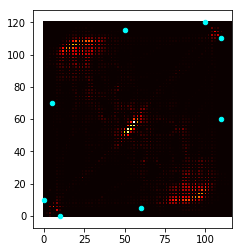

In [107]:
# Plot the heatmap
plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', origin='lower')
x = [5,50,60,110,0,100,10,110] 
y = [70,115,5,60,10,120,0,110] 
plt.scatter(x, y, c='cyan', s=20)
plt.show()

In [108]:
# Define the points for each line
top_start = (5, 70)
top_end = (50, 115)

mid_top_start = (0, 10)
mid_top_end = (100, 120)

mid_bottom_start = (10, 0)
mid_bottom_end = (110, 110)

bottom_start = (60, 5)
bottom_end = (110, 60)

left_start = top_start
left_end = bottom_start

right_start = top_end
right_end = bottom_end

In [91]:
def get_region(x, y):
    if y > calculate_y(top_start, top_end, x):
        return "top"
    elif y < calculate_y(bottom_start, bottom_end, x):
        return "bottom"
    elif (
        y > calculate_y(left_start, left_end, x)
        and y > calculate_y(mid_bottom_start, mid_bottom_end, x)
        and y < calculate_y(right_start, right_end, x)
        and y < calculate_y(mid_top_start, mid_top_end, x)
    ):
        return "mid"
    else:
        return "roaming"

def calculate_y(point1, point2, x):
    x1, y1 = point1
    x2, y2 = point2

    # Calculate the y-coordinate using the two-point form of the line equation
    return y1 + (y2 - y1) * (x - x1) / (x2 - x1)

# Example points
points = [(81, 5), (5, 108), (25, 25), (55, 60)]

# Determine the region for each point
for point in points:
    x, y = point
    region = get_region(x, y)
    print("Point", point, "is", region)


Point (81, 5) is bottom
Point (5, 108) is top
Point (25, 25) is roaming
Point (55, 60) is mid


In [142]:
# Define the regions
regions = ["top", "bottom", "mid", "roaming"]

# Reset the index of the earthshaker_rows DataFrame
earthshaker_rows = earthshaker_rows.reset_index(drop=True)

agg_data = {}

# Iterate over each player's dictionary and add up the seconds spent in each region
for i, player_data in enumerate(earthshaker_rows['lane_pos']):
    player_data = ast.literal_eval(player_data)
    player_region_counts = {region: 0 for region in regions}  # Initialize counts for each region
    total_seconds = sum(sum(y_dict.values()) for y_dict in player_data.values())  # Calculate total seconds for player

    for x, y_dict in player_data.items():
        x = int(x)
        for y, seconds in y_dict.items():
            y = int(y)
            region = get_region(x, y)
            player_region_counts[region] += seconds

    # Calculate the fraction of seconds spent in each region
    player_region_fractions = {region: count / total_seconds for region, count in player_region_counts.items()}

    # Append player's region fractions to aggregated data
    agg_data[i] = {**player_region_fractions, 'team': earthshaker_rows.loc[i, 'team']}

# Create a new DataFrame from the aggregated data
lane_info = pd.DataFrame.from_dict(agg_data, orient='index')

# Print the resulting DataFrame
print(lane_info)


         top    bottom       mid   roaming  team
0   0.536903  0.000000  0.020260  0.442836     1
1   0.000000  0.814493  0.000000  0.185507     0
2   0.334783  0.000000  0.017391  0.647826     1
3   0.000000  0.000000  0.008696  0.991304     1
4   0.457971  0.000000  0.011594  0.530435     1
5   0.768116  0.000000  0.068116  0.163768     1
6   0.355072  0.008696  0.030435  0.605797     1
7   0.446377  0.000000  0.008696  0.544928     1
8   0.808696  0.000000  0.026087  0.165217     1
9   0.000000  0.000000  0.023188  0.976812     1
10  0.684058  0.000000  0.026087  0.289855     1
11  0.000000  0.621190  0.000000  0.378810     0
12  0.000000  0.379710  0.043478  0.576812     1
13  0.015942  0.649275  0.000000  0.334783     0
14  0.719884  0.000000  0.010160  0.269956     1
15  0.000000  0.589855  0.000000  0.410145     0
16  0.000000  0.802899  0.000000  0.197101     0
17  0.000000  0.000000  0.023188  0.976812     1
18  0.263768  0.123188  0.030435  0.582609     1
19  0.000000  0.0000

In [143]:
# save lane_info to a file
with open('lane_info_df.pickle', 'wb') as f:
    pickle.dump(lane_info, f)